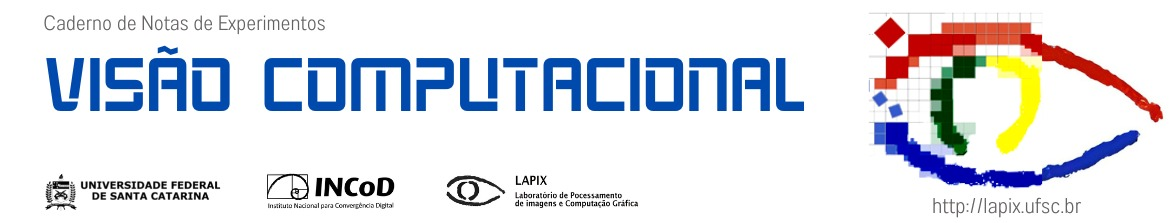






<a href="https://colab.research.google.com/github/awangenh/vision/blob/master/jupyter/02.2.Dom%C3%ADnios%20do%20Valor%20e%20Espa%C3%A7o%20-%20Sistema%20Seletivo%20de%20Detec%C3%A7%C3%A3o%20de%20Intrusos.ipynb"><img align="left"  src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>&nbsp; &nbsp;<a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/License-CC-BY-ND-4.0-orange.png" alt="Creative Commons 4.0 License" title="Creative Commons 4.0 License"></a>&nbsp; &nbsp; <a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/Jupyter-Notebook-v.1.0-blue.png" alt="Jupyter Version" title="Jupyter Version"></a>&nbsp; &nbsp;<a href=""><img align="left"  src="https://img.shields.io/badge/python-3.10-green" alt="Python Version" title="Python Version"></a>

# 02.2 Sistema Seletivo de Detecção de Intrusos

Neste caderno de notas você vai desenvolver as três primeiras etapas da *pipeline* de um sistema seletivo de detecção de intrusos que diferencia entre humanos andando por uma área monitorada e os cães de guarda desta área: o sistema deve soar um alarme sempre que um humano aparece caminhando pela cena mas deve ignorar os cães. 

Para isso você vai aprender a aplicar uma combinação de métodos nos domínios do valor e do espaço, estendendo O que você já viu no exercício do detector de carros feito anteriormente, e também aprender a extrair características de objetos para sua posterior classificação. 

Vamos ver o que esta, que parece ser uma tarefa complexa onde você necessita diferenciar entre humanos e cães, na verdade pode ser desenvolvida com métodos muito simples e que podem, se necessário, ser embarcados em uma câmara de vigilância.


### Info on Jupyter Notebooks

Look here: 
 * [LAPIX::Jupyter Notebooks na UFSC (Seminário para Professores do INE2019.1)](http://www.lapix.ufsc.br/jupyter-notebooks-na-ufsc/)
 * [LAPIX::Como Importar Jupyter Notebooks de GitHub para Google Colab?](http://www.lapix.ufsc.br/ensino/como-importar-jupyter-notebooks-de-github-para-google-colab/)

# Initializations

### Checking where you're running...

In [1]:
!uname -a
!cat /etc/lsb-release

Linux note 5.15.0-50-generic #56-Ubuntu SMP Tue Sep 20 13:23:26 UTC 2022 x86_64 x86_64 x86_64 GNU/Linux
DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=22.04
DISTRIB_CODENAME=jammy
DISTRIB_DESCRIPTION="Ubuntu 22.04.1 LTS"


### Cloning the ***Computer Vision*** repository from a Git

If you're running this at your computer or using Google Colab but **not** using your Google Drive, this is the way to use these notebooks!

In [ ]:
# To clone from our personal Github mirror (may be out of sync):
!git clone https://github.com/awangenh/vision

In [ ]:
# To clone from UFSC's Institutional Gitlab (always the latest version):
!git clone https://codigos.ufsc.br/aldo.vw/vision

### Common Installations and Initializations

If you are at your computer at home and have installed Anaconda, what needs to be additionally installed?

In [ ]:
# Install latest OpenCV with Python Interface using the Python Install Program
!pip3 install opencv-python

In [2]:
%reload_ext autoreload
%autoreload 2

# Make matplotlib draw graphics directly onto the notebook and not in a window
%matplotlib inline

# Intrusos X Cães da Casa

## Morfologia Matemática e Extração de Características Simples

As imagens adiante simulam imagens captadas por um sistema de vigilância eletrônica na varanda de uma casa. O objetivo é que o sistema detecte intrusos e o alarme dispare sempre que um intruso for detectado, mas que o sistema não reaja às movimentações dos cães da casa. 

*Intruso* é todo objeto estranho na cena similar o suficiente a um ser humano. Outros objetos devem ser identificados, mas não devem fazer com que o alarme dispare. Isto é importante pois esta casa possui cães e estes também devem ser monitorados, para que se possa produzir estatísticas de suas andanças pelo terreno (um sumiço dos cães pode ser um sinal de alarme, mas isto é um detalhe que deve ser decidido por uma instância superior do sistema e que não importa aqui - importante é que os cães devem ser detectados também). 

Um outro problema com o qual se deve operar é o fato de que as câmaras estão presas a suportes de metal com alguma flexibilidade e as cenas podem sofrer pequenas modificações de posição em função de balanços da haste por causa de vento ou dilatação do metal. 

Exemplos de cenas tomadas estão abaixo. Este é evidentemente um problema que pode ser abordado inicialmente como no caso-exemplo do pardal eletrônico visto na aula inicial: podemos começar identificando o que se modificou na cena através da utilização de uma imagem-modelo e da subtração da cena atual desta imagem-modelo. Tentaremos identificar objetos na cena sempre que as discrepâncias entre modelo e imagem atual forem maiores que um limiar. 

Observe que aqui existe outro fator dificultante, pois além do fato de que variações de luz e de posição da câmera podem introduzir ruídos, o fundo é claro e alguns dos cães também são claros. 

Nas próximas células vamos resolver passo a passo este problema para estas imagens aqui, ressaltando os pontos difíceis e o que é insolúvel. 

*Obs: Entre 2002 e 2018 este foi sempre o trabalho final da disciplina INE 5443 Reconhecimento de Padrões.* 

## 1.Cenas de Fundo, Cães e Intrusos

<table BORDER=0 CELLSPACING=4 COLS=2 >
<tr>
<td><a href="../data/porta1pb.jpg"><img SRC="../data/porta1.jpg" height=240 width=273></a></td>

<td><a href="../data/porta2pb.jpg"><img SRC="../data/porta2.jpg" height=240 width=273></a></td>
</tr>

<tr>
<td><a href="../data/larapiopb.jpg"><img SRC="../data/larapio.jpg" height=240 width=273></a></td>

<td><a href="../data/sergiopb.jpg"><img SRC="../data/sergio.jpg" height=240 width=273></a></td>
</tr>

<tr>
<td><a href="../data/kirra1pb.jpg"><img SRC="../data/kirra1.jpg" height=240 width=273></a></td>

<td><a href="../data/kirra2pb.jpg"><img SRC="../data/kirra2.jpg" height=240 width=273></a></td>
</tr>

<tr>
<td><a href="../data/branquinha1pb.jpg"><img SRC="../data/branquinha1.jpg" height=240 width=273></a></td>

<td><a href="../data/branquinha2pb.jpg"><img SRC="../data/branquinha2.jpg" height=240 width=273></a></td>
</tr>

<tr>
<td><a href="../data/branquinha3pb.jpg"><img SRC="../data/branquinha3.jpg" height=240 width=273></a></td>

<td>
</td>
</tr>
</table>

Você pode baixar a versão em tons de cinza das imagens clicando nelas, mas nós já aprendemos a transformar as imagens a cores então vamosreusar este código abaixo: 

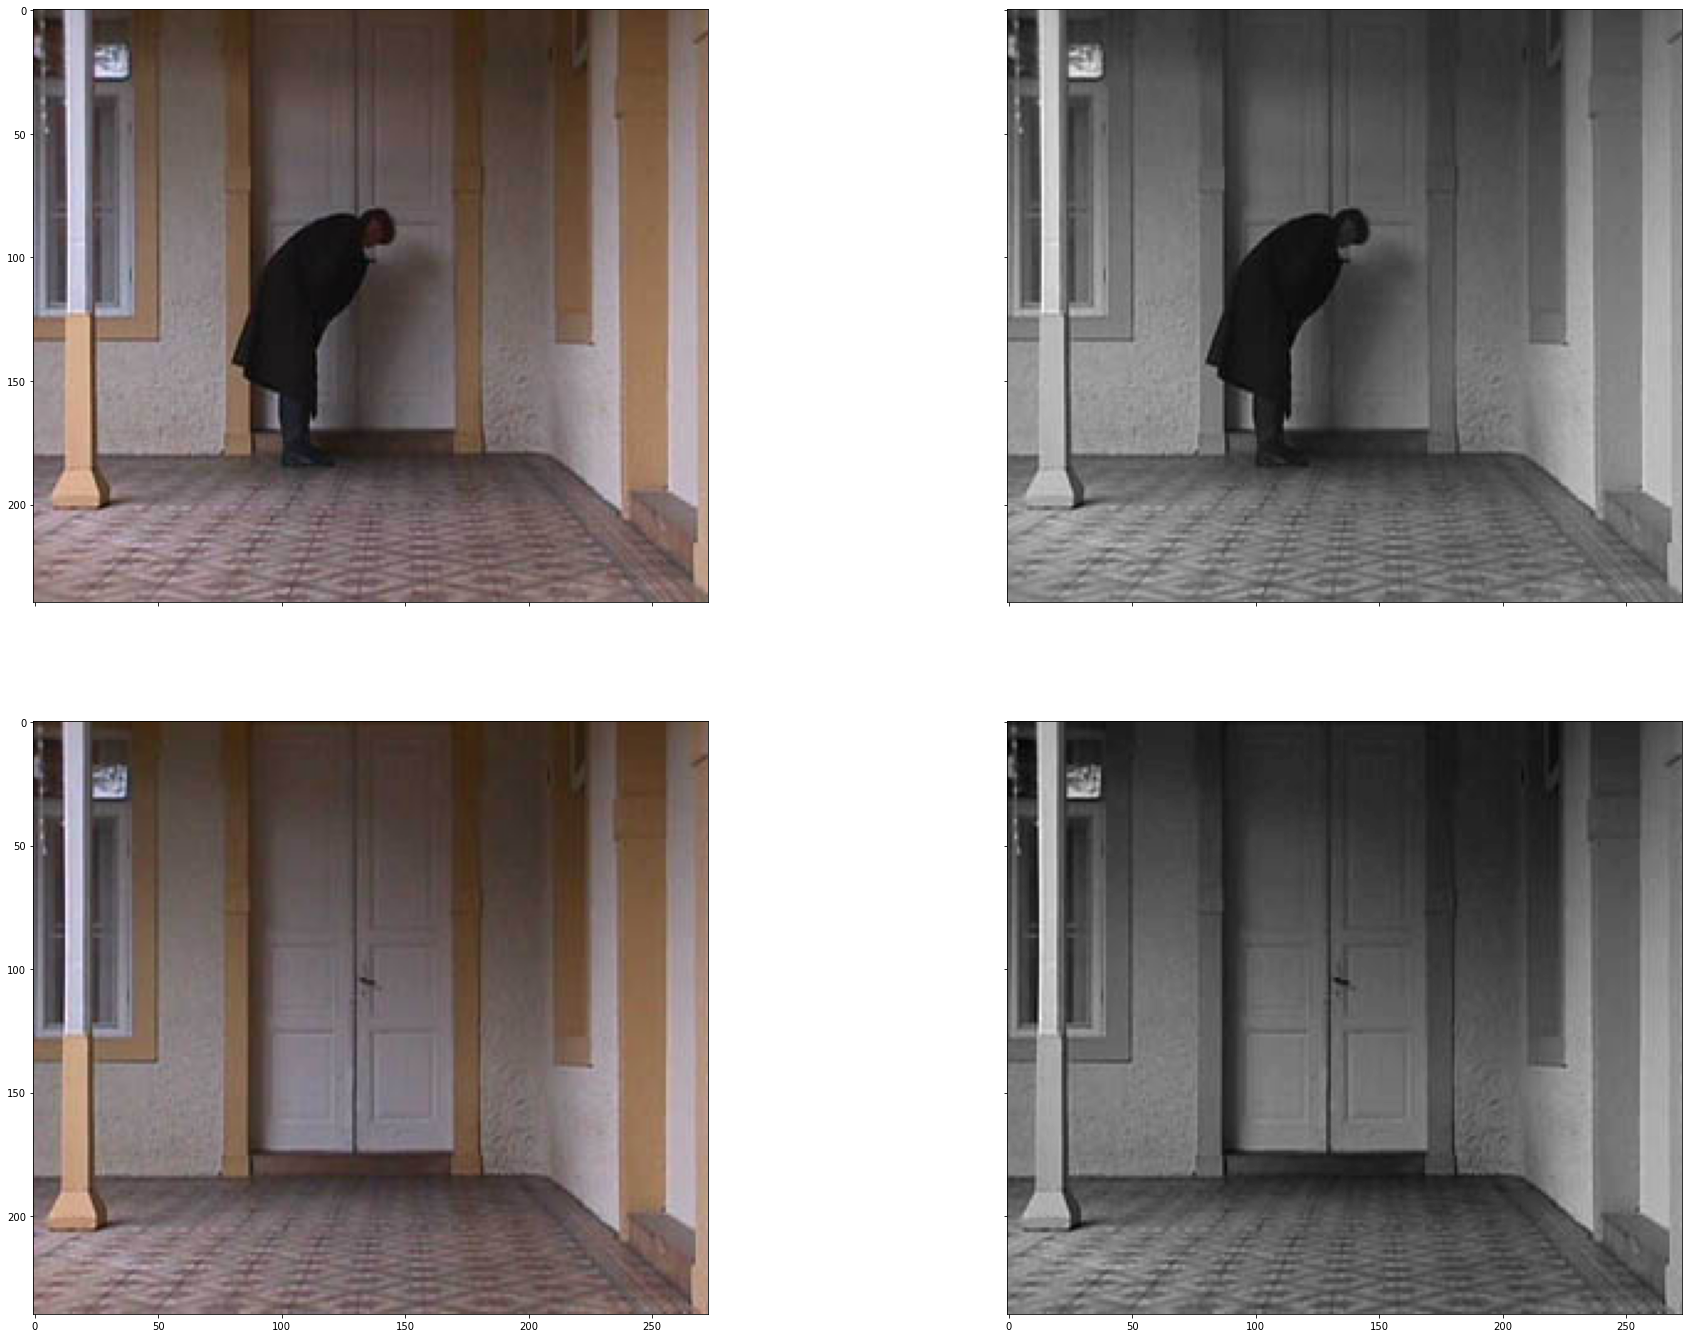

In [3]:
import cv2
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
# Import interaction widgets and functions
from ipywidgets import interact, interactive, interact_manual

# Load the image in color (OpenCV standard = BGR)
orig = cv2.imread("../data/larapio.jpg", cv2.IMREAD_COLOR)
# Convert to RGB
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

# Load the image in grayscale
gray = cv2.imread("../data/larapio.jpg", cv2.IMREAD_GRAYSCALE)

# Load the reference image in color (OpenCV standard = BGR)
ref_orig = cv2.imread("../data/porta1.jpg", cv2.IMREAD_COLOR)
# Convert to RGB
ref_orig = cv2.cvtColor(ref_orig, cv2.COLOR_BGR2RGB)

# Load the reference image in grayscale
ref_gray = cv2.imread("../data/porta1.jpg", cv2.IMREAD_GRAYSCALE)


fig, axes = plt.subplots(2, 2, figsize=(32, 24), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(orig)
ax[1].imshow(gray, 'gray')
ax[2].imshow(ref_orig)
ax[3].imshow(ref_gray, 'gray')

## 2.Detectando Diferenças entre Imagem-Modelo e Imagem Atual geradas por Movimento na Cena

A primeira parte deste trabalho, como foi dito, nós já discutimos no exemplo dos pardais de semáforo dado no início da parte de imagens da disciplina: a melhor forma de se detectar um movimento ou uma alteração em uma cena é realizar-se uma subtração entre a cena na qual se está procurando pela alteração e uma cena-modelo, que poderia, por exemplo ser uma imagem anterior, onde não se detectou nada. Usar uma cena recente como modelo evita que alterações de luminosidade do dia ou diferenças na distribuição de sujeira pelo chão influenciem o processo. 

A primeira parte do processo é bastante simples, basta tomar uma imagem-modelo e calcular a diferença absoluta pixe-a-pixel com a imagem atual. O resultado é mostrado na segunda coluna da tabela 1. 

Feito isto, precisamos decidir quais diferenças ignoramos, considerando-as variações de luminosidade irrelevantes e quais vamos considerar. Para isto tomamos o threshold, setando o valor de 50 como valor de corte, acima do qual consideraremos a diferença como relevante. Este valor é arbitrário e você deve testar com vários outros, para ver o que funciona melhor. 

Observe as imagens abaixo e veja que o movimento do Sol entre a tomada a imagem de referência e a imagem com um intruso já gera artefatos nos postes da varanda em função da posição diferente do Sol. 

<table BORDER CELLSPACING=4 CELLPADDING=0 COLS=3 NOSAVE >
<caption><b><font face="Arial,Helvetica"><font size=-1>Exemplo de identifica&ccedil;&atilde;o
das modifica&ccedil;&otilde;es ocorridas na cena com um limiar de 50</font></font></b></caption>

<tr>
<td><img SRC="../data/larapiopb.jpg" height=240 width=273></td>

<td><img SRC="../data/diff-larapio.jpg" height=240 width=273></td>

<td><img SRC="../data/larapiopb-thresh.jpg" height=240 width=273></td>
</tr>

<tr>
<td><img SRC="../data/sergiopb.jpg" height=240 width=273></td>

<td><img SRC="../data/diff-sergio.jpg" height=240 width=273></td>

<td><img SRC="../data/sergiopb-thresh.jpg" height=240 width=273></td>
</tr>

<tr>
<td><img SRC="../data/kirra1pb.jpg" height=240 width=273></td>

<td><img SRC="../data/diff-kirra1.jpg" height=240 width=273></td>

<td><img SRC="../data/thresh-kirra1.jpg" height=240 width=273></td>
</tr>

<tr>
<td><img SRC="../data/kirra2pb.jpg" height=240 width=273></td>

<td><img SRC="../data/diff-kirra2.jpg" height=240 width=273></td>

<td><img SRC="../data/thresh-kirra2.jpg" height=240 width=273></td>
</tr>

<tr>
<td><img SRC="../data/branquinha1pb.jpg" height=240 width=273></td>

<td><img SRC="../data/diff-branquinha1.jpg" height=240 width=273></td>

<td><img SRC="../data/branquinha1-thresh.jpg" height=240 width=273></td>
</tr>
</table>

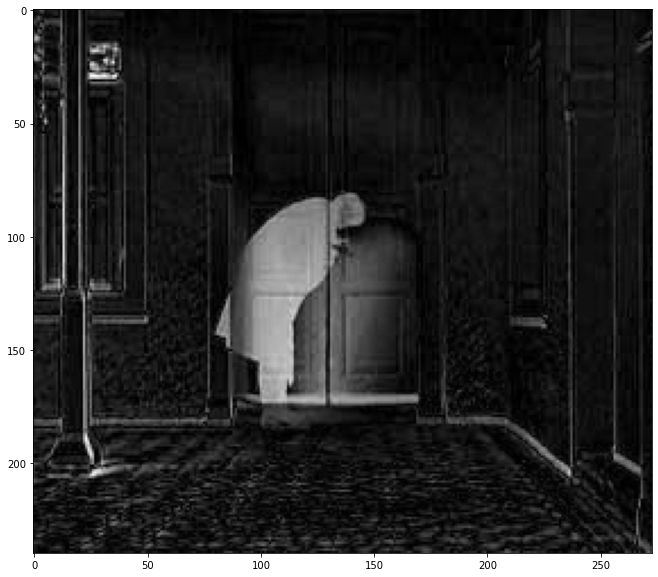

In [10]:
# Calculate the absolute difference between two images
# Image order is irrelevant since we will discard the sign
change = cv2.absdiff(gray, ref_gray)
# Set the size to show
plt.figure(figsize = (12,10))
# Show it!
plt.imshow(change, 'gray')

### Olhando o resultado com um mapa de calor...

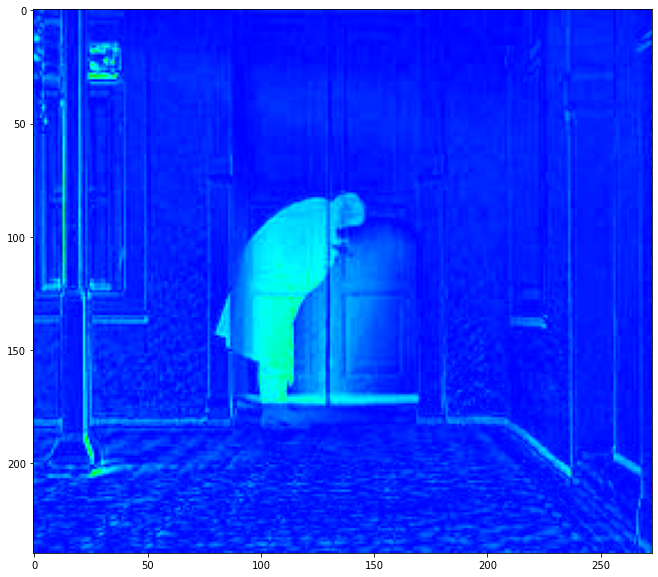

In [22]:
heatmap = cv2.applyColorMap(change, cv2.COLORMAP_RAINBOW)

plt.figure(figsize = (12,10))
# Show it!
plt.imshow(heatmap)

### Vamos binarizar...

Este passo você já viu no detector de carros.

In [11]:
modes = ['cv2.THRESH_BINARY',
         'cv2.THRESH_BINARY_INV',
         'cv2.THRESH_TRUNC',
         'cv2.THRESH_TOZERO',
         'cv2.THRESH_TOZERO_INV']

# Basic threshold example
def my_threshold(thresh, modeStr):
    global change
    global dst
    mode = eval(modeStr)
    th, dst = cv2.threshold(change, thresh, 255, mode)
    fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(change,'gray')
    ax[1].imshow(dst,'gray')

# Pass function & its parameters to interactive
interactive(my_threshold, thresh = (0, 255), modeStr=modes)

# If your using Google Colab, comment the line above and use this here...
# my_threshold(25, 'cv2.THRESH_BINARY')

interactive(children=(IntSlider(value=127, description='thresh', max=255), Dropdown(description='modeStr', opt…

## 3 Eliminando Ru&iacute;dos gerados por Movimento da C&acirc;mera e Isolando os Objetos&nbsp; atrav&eacute;s de Morfologia Matem&aacute;tica

Depois que n&oacute;s geramos
uma imagem binarizada a partir da diferen&ccedil;a entre as imagens modelo
e atual, a qual cont&eacute;m as diferen&ccedil;as relevantes entre a imagem-modelo
e uma imagem qualquer, temos de eliminar ru&iacute;dos (como por exemplo
os reflexos vari&aacute;veis na janela de cima) e os artefatos originados
pelo movimento da c&acirc;mera (vis&iacute;veis sob a forma de tra&ccedil;os
verticais e horizontais). A imagem abaixo ilustra bem os problemas que
enfrentamos:


<p><center> <p><img SRC="../data/larapiopb-thresh.jpg" BORDER=1></center>

As setas vermelhas indicam
artefatos de movimento verticais e horizontais e os reflexos na janela
s&atilde;o bastante vis&iacute;veis &agrave; esquerda, em cima. A grande
maioria destes ru&iacute;dos possue caracter&iacute;sticas similares: s&atilde;o
finos riscos. A morfologia matem&aacute;tica nos oferece as ferramentas
de que necessitamos para eliminar estes artefatos.&nbsp;

Para eliminar riscos podemos
utilizar uma opera&ccedil;&atilde;o de abertura morfol&oacute;gica (eros&atilde;o
seguida de dilata&ccedil;&atilde;o) com a utiliza&ccedil;&atilde;o de um
kernel que possua caracter&iacute;sticas contr&aacute;rias &agrave;s da
estrutura que queremos eliminar na imagem. Realizamos uma abertura e n&atilde;o
simplesmente uma eros&atilde;o porque queremos reconstituir o resto da
imagem, que n&atilde;o possue estas caracter&iacute;sticas. Assim afetamos
apenas aquilo que queremos eliminar.&nbsp;
    
Para isto utilizamos um kernel
tamb&eacute;m em forma de risco, mas perpendicular ao risco a ser eliminado.
Para isso realizamos primeiramente uma abertura com um kernel horizontal,
eliminando os riscos verticais, como ilustrado abaixo:
    
    
<p><center>
<p><img SRC="../data/elim-vertical.jpg" BORDER=1></center>
    
    
Depois realizamos outra abertura,
aplicada ao resultado da anterior, utilizando um kernel vertical, para
eliminar riscos horizontais, como mostrado na pr&oacute;xima figura:
    
<p><center><p><img SRC="../data/elim-horizontal.jpg" BORDER=1></center>
  
    
O resultado, como pode ser
visto, &eacute; uma imagem onde o ru&iacute;do foi quase totalmente eliminado,
mas as estruturas "interessantes" foram preservadas. Como trataremos o
ru&iacute;do remanescente veremos mais tarde. Podemos realizar esta filtragem
de riscos com um kernel criado por n&oacute;s e os opera&ccedil;&otilde;es
de eros&atilde;o e dilata&ccedil;&atilde;o oferecidas pelos pacotes OpenCV ou Scikit doPython.
    
Como o m&eacute;todo de elimina&ccedil;&atilde;o
de ru&iacute;dos carece de intelig&ecirc;ncia e j&aacute; foi aplicado
sobre uma imagem um tanto quanto mutilada atrav&eacute;s da subtra&ccedil;&atilde;o
de imagens realizada anteriormente, muitas coisas da imagem foram perdidas.
Para podermos continuar, devemos tentar realizar uma reconstru&ccedil;&atilde;o
dos peda&ccedil;os que obtivemos como resultados das opera&ccedil;&otilde;es
realizadas at&eacute; o momento. Isto vai facilitar o nosso trabalho, pois
no momento temos v&aacute;rios peda&ccedil;os representando o nosso objeto
de interesse.
    
Isto pode ser realizado com
uma opera&ccedil;&atilde;o morfol&oacute;gica de fechamento (dilata&ccedil;&atilde;o
seguida de eros&atilde;o) realizada com um kernel sim&eacute;trico em rela&ccedil;&atilde;o
a <i>x</i> e a <i>y</i>.&nbsp; A opera&ccedil;&atilde;o de fechamento tem
a propriedade de ligar objetos pr&oacute;ximos, por&eacute;m desconectados,
sem afetar o resto da imagem.&nbsp; Para tanto vamos gerar um kernel circular
de tamanho razo&aacute;vel (11 pixel) e aplicar o fechamento utilizando
este kernel. Acreditamos que para as imagens que temos nesta aplica&ccedil;&atilde;o
isto ser&aacute; suficiente. O resultado para a imagem acima pode ser visto
abaixo:
    
<p><center>
<p><img SRC="../data/fechamento-final.jpg" BORDER=1 height=240 width=273></center>

    
O resultado parece bastante
bom. Unimos a silhueta do intruso &agrave; sua sombra, mas isto n&atilde;o
era poss&iacute;vel de se evitar, pois a informa&ccedil;&atilde;o de sombra
&eacute; indistingu&iacute;vel de objetos reais quando trabalhamos em imagens
de tons de cinza. Se trabalh&aacute;ssemos com imagens coloridas, poder&iacute;amos
ter tentado ignorar aqueles resultados da subtra&ccedil;&atilde;o de imagens,
onde a imagem s&oacute; escureceu, mas manteve seu tom de cor anterior - mas isso tamb&eacute;m n&atilde;o funciona sempre.&nbsp;
    
    
Al&eacute;m do intruso, a
imagem resultante tamb&eacute;m cont&eacute;m dois outros objetos, que
s&atilde;o ru&iacute;do.&nbsp; O pr&oacute;ximo passo ser&aacute; classificar
os objetos de forma e tentar reconhecer se algum deles &eacute; um c&atilde;o
ou um intruso. Isto ser&aacute; visto na pr&oacute;xima p&aacute;gina.
    
    
Abaixo voc&ecirc; pode ver
os resultados de se aplicar esta t&eacute;cnica para as outras imagens
desta s&eacute;rie. Observe que nem todas possuem tanto ru&iacute;do como
esta aqui acima, mas na maioria dos casos isto n&atilde;o afetou o resultado.
O c&atilde;o teve suas patas amputadas na primeira imagem mostrando um
cachorro. Isto &eacute; quase inevit&aacute;vel em fun&ccedil;&atilde;o
do filtro de linhas verticais (humanos possuem pernas relativamente mais
grossas e n&atilde;o s&atilde;o afetados), mas o objeto resultante possue
uma forma t&atilde;o diferente da de um humano, que isto n&atilde;o dever&aacute;
colocar problemas. O maior problema surge com o c&atilde;o branco, que
se confunde com a parede e &eacute; praticamente eliminado.
    
<p>
<table BORDER CELLSPACING=4 CELLPADDING=0 COLS=3 NOSAVE >
Tabela 2: Resultados das opera&ccedil;&otilde;es morfol&oacute;gicas para as imagens-exemplo
<tr NOSAVE>
<td NOSAVE><b>LIMIAR.</b> Imagem limiarizada ap&oacute;s opera&ccedil;&atilde;o morfol&oacute;gica de <b>abertura</b> com kernel horizontal longo e fino para elimina&ccedil;&atilde;o de linhas
verticais perdidas na cena.&nbsp;</td>

<td NOSAVE><b>RUIDO</b>. Imagem anterior ap&oacute;s
opera&ccedil;&atilde;o morfol&oacute;gica de <b>abertura</b> com kernel
vertical longo e fino para elimina&ccedil;&atilde;o de linhas horizontais
perdidas na cena.&nbsp;</td>

<td>Imagem ap&oacute;s opera&ccedil;&atilde;o morfol&oacute;gica de <b>fechamento</b> com kernel circular grande para elimina&ccedil;&atilde;o de divis&otilde;es dos objetos da cena. Em muitos casos a sombra do objeto &eacute; integrada</td>
</tr>

<tr>
<td><img SRC="../data/elim-vertical.jpg" height=240 width=273></td>

<td><img SRC="../data/elim-horizontal.jpg" height=240 width=273></td>

<td><img SRC="../data/fechamento-final.jpg" height=240 width=273></td>
</tr>

<tr>
<td><img SRC="../data/elim-vertical-sergio.jpg" height=240 width=273></td>

<td><img SRC="../data/elim-horizontal-sergio.jpg" height=240 width=273></td>

<td><img SRC="../data/fechamento-sergio.jpg" height=240 width=273></td>
</tr>

<tr>
<td><img SRC="../data/elim-vertical-kirra1.jpg" height=240 width=273></td>

<td><img SRC="../data/elim-horizontal-kirra1.jpg" height=240 width=273></td>

<td><img SRC="../data/fechamento-kirra1.jpg" height=240 width=273></td>
</tr>

<tr>
<td><img SRC="../data/elim-vertical-kirra2.jpg" height=240 width=273></td>

<td><img SRC="../data/elim-horizontal-kirra2.jpg" height=240 width=273></td>

<td><img SRC="../data/fechamento-kirra2.jpg" height=240 width=273></td>
</tr>

<tr>
<td><img SRC="../data/elim-vertical-branquinha.jpg" height=240 width=273></td>

<td><img SRC="../data/elim-horizontal-branquinha.jpg" height=240 width=273></td>

<td><img SRC="../data/fechamento-branquinha.jpg" height=240 width=273></td>
</tr>
</table>

In [17]:
# Horizontal Kernel
kernel = np.ones((1,5),np.uint8)
kernel

array([[1, 1, 1, 1, 1]], dtype=uint8)

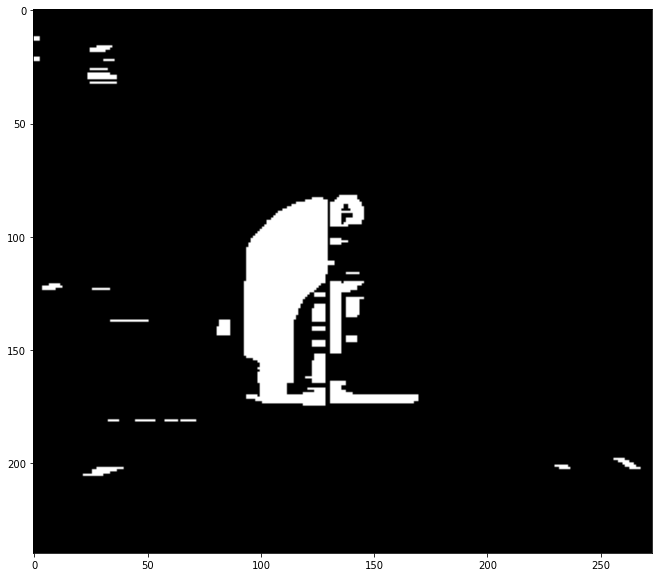

In [18]:
import numpy as np
import cv2

opening = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel)
# Set the size to show
plt.figure(figsize = (12,10))
# Show it!
plt.imshow(opening, 'gray')

In [19]:
# Vertical Kernel
kernel = np.ones((5,1),np.uint8)
kernel

array([[1],
       [1],
       [1],
       [1],
       [1]], dtype=uint8)

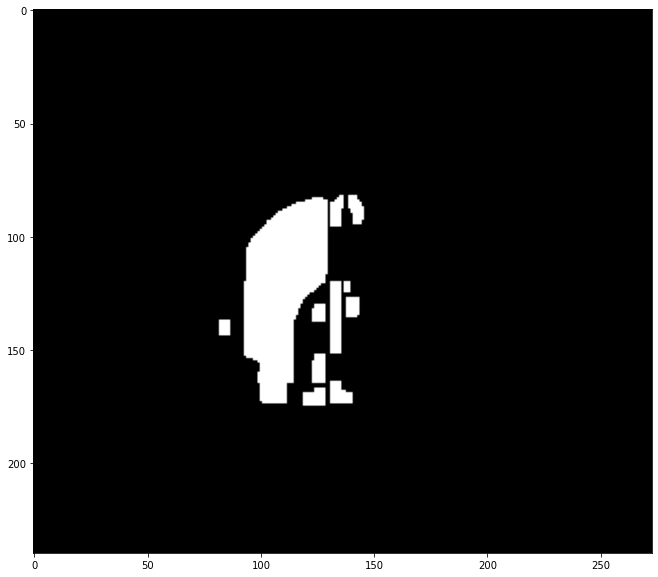

In [20]:
opening2 = cv2.morphologyEx(opening, cv2.MORPH_OPEN, kernel)
# Set the size to show
plt.figure(figsize = (12,10))
# Show it!
plt.imshow(opening2, 'gray')

### Execute um fechamento com um Kernel generoso...

Vamos agora transformar estes bloquinhos em objetos consistentes/

In [21]:
def myKernel(size):
    global kernel2
    kernel2 = np.ones((size,size),np.uint8)
    print(kernel2)

interactive(myKernel, size=(5,55,2))

interactive(children=(IntSlider(value=29, description='size', max=55, min=5, step=2), Output()), _dom_classes=…

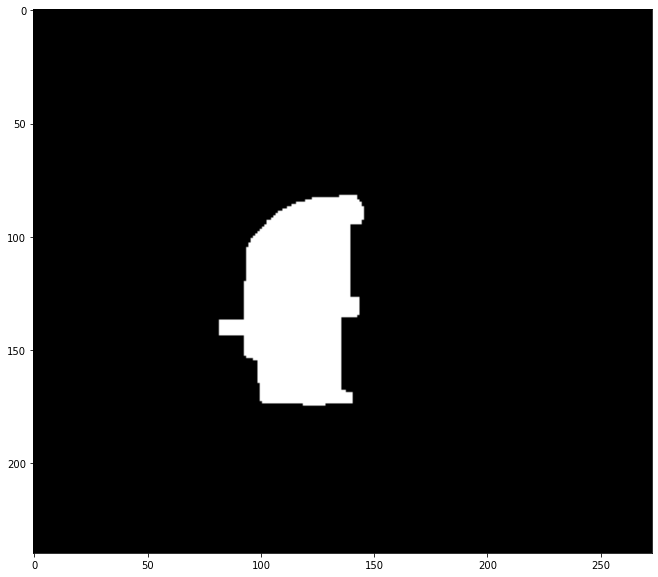

In [22]:
closing = cv2.morphologyEx(opening2, cv2.MORPH_CLOSE, kernel2)
# Set the size to show
plt.figure(figsize = (12,10))
# Show it!
plt.imshow(closing, 'gray')

## 4. Calculando Atributos dos Objetos para Realizar a Classificação dos Mesmos

Depois de encontrar um conjunto de passos de processamento para filtrar suficientemente a imagem para conseguir separar e tornar conexo o objeto de interesse (e mais alguns outros objetos) do resto da imagem, o próximo passo é gerar uma descrição desses objetos, de forma a que possamos classificá-los adequadamente e, caso necessário, reagir a uma situação onde um intruso foi detectado.

A nossa aplicação deverá possuir a capacidade de gerar atributos que permitam classificar os objetos encontrados nas imagens em três categorias distintas:

1. intruso (ser humano);
2. animal (cães de guarda);
3. ruído (qualquer outra coisa).

Para realizar isto, nós vamos tomar a imagem resultante da última operação do passo anterior, o fechamento, e proceder com as seguintes operações:

1. Realizar uma **rotulação** das componentes conexas resultantes do fechamento, identificando cada componente como um objeto separado.
2. Gerar um conjunto de **atributos descritores** para cada uma dos objetos encontrados. Estes atributos devem ser significativos e descrever características importantes dos objetos, tais como posição de seu centróide, bounding box, componentes principais, inclinação, etc. É neste passo que nós vamos gerar um padrão para ser reconhecido.
3. Analisar estes atributos para ver quais são característicos os suficiente para cada grupo para serem usados para alimentar um **classificador** de nossa escolha. Por fim vamos escolher um classificador (rede neural, k-NN, método estatístico, regras, if-then-else programático) para realizar o passo 
4. a classificação. Mas isto é por sua conta e só vamos dar um toque no fim deste notebook...


### Ideia: relações de área e altura/largura nos permitem diferenciar entre humanos e cães

Um humano sempre é grande e tem seu eixo principal na vertical, enquanto que um cão o tem na horizontal (se visto de lado) ou então é pequeno (se visto de frente)....

<p><center><img SRC="../data/eixos-silhueta.jpg" BORDER=1 height=240 width=273></center></p>

Vamos usar a seguinte biblioteca:

* https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_label.html
* https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html
* https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops
* https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops_table

### Exemplos de Algumas Propriedades Simples

In [23]:
# Propriedades simples de regiões em imagens
# Imagem deve ter uma região bem evidente
# Podemos primeiro extrair as componentes conexas com label(image)
from skimage.measure import regionprops, regionprops_table

stats = regionprops(closing.astype(int))

# Tome a primeira região
props = stats[0]

# Mostre algumas propriedades
print('Eixo principal: \t', props['minor_axis_length'])
print('Eixo secundário: \t', props['major_axis_length'])
print('Centro geométrico: \t', props['centroid'])
print('Ângulo do eixo principal: ', props['orientation'])
print('Área do objeto: \t', props['area'])

Eixo principal: 	 53.438888077925
Eixo secundário: 	 100.26813828330825
Centro geométrico: 	 (128.36082212636387, 117.19690433900026)
Ângulo do eixo principal:  -0.12105078587741404
Área do objeto: 	 3941


### Agora um Exemplo Útil

Vamos usar a biblioteca de extração de características simples de uma forma mais criativa

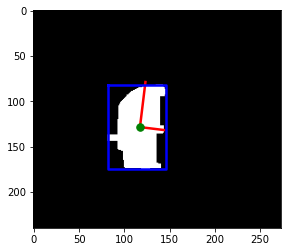

<Figure size 864x720 with 0 Axes>

In [24]:
# Propriedades simples de regiões em imagens
# Imagem deve ter uma região bem evidente
# Podemos primeiro extrair as componentes conexas com label(image)
import math
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate

# Podemos primeiro identificar as componentes conexas com label()
imagem_rotulada = label(closing)
# Extraímos componentes individuais com regionprops()
regions = regionprops(imagem_rotulada)

# Tomamos a única região
props = regions[0]

fig, ax = plt.subplots()
plt.figure(figsize = (12,10))

ax.imshow(closing, cmap=plt.cm.gray)

# Desenhamos o centróide e os eixos principais
y0, x0 = props.centroid
orientation = props.orientation
x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length

ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
ax.plot(x0, y0, '.g', markersize=15)

# Desenhamos o casco convexo
minr, minc, maxr, maxc = props.bbox
bx = (minc, maxc, maxc, minc, minc)
by = (minr, minr, maxr, maxr, minr)
ax.plot(bx, by, '-b', linewidth=2.5)


plt.show()


## Classificação

Agora você necessita de algum método para classificar estes parâmetros em "intruso" e "cachorro".  Veja nossa aula sobre *SVM -Support Vector Machines*.

![rodape lapix ufsc](../rodape-CC.png)